<a href="https://colab.research.google.com/github/Nateme16/geo-aquawatch-water-quality/blob/main/Solid_Nate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start building SOLID with S2 SR while Acolite version is sorted


In [63]:
!pip install geemap --quiet

In [64]:
import geemap

In [65]:
#Map = geemap.Map(center=[42,-71], zoom= 9)
#Map

Get s2 sr imagery for Narragansett Bay region

In [66]:
import ee
NBay = ee.Geometry.Polygon(
        [[[-71.44643316430347, 41.92140472212022],
          [-71.53981695336597, 41.48257061731345],
          [-71.47939214867847, 41.3383770483458],
          [-71.16078863305347, 41.42699101424345],
          [-71.16095830370352, 41.64257191827559],
          [-70.97676763695972, 41.88869830740288],
          [-71.15111544654354, 41.97883748042962]]])

imageVisParam = {"opacity":1,"bands":["B4","B3","B2"],"min":-560.1588934829267,"max":2614.3187289464204,"gamma":1}

In [67]:
area=NBay
#Time window
startyear = 2020
endyear = 2020;
startmonth = 1
endmonth = 12

imageCollection = ee.ImageCollection("COPERNICUS/S2_SR")\
  .filterBounds(area)\
  .filter(ee.Filter.lt('HIGH_PROBA_CLOUDS_PERCENTAGE',10))\
  .filter(ee.Filter.calendarRange(startyear,endyear,'year'))\
  .filter(ee.Filter.calendarRange(startmonth,endmonth,'month'))\
  .sort('system:time_start')\
  .set('SENSOR_ID', 'OLI_TIRS')

#old s2 cloudmask and water, there is a different new one, but keeping it simple
def cloudmask(img):
                  mask = img.select(['SCL']).eq(6)
                  notcloud=img.select(['QA60']).eq(0)
                  img=img.updateMask(mask)
                  img=img.updateMask(notcloud)
                  return img

imageCollection = imageCollection.map(cloudmask)

#Map.addLayer(imageCollection.median(),imageVisParam,"result1")


Keep just one image to learn on and classify the "type" of SOLID water


In [68]:

#image = ee.Image(imageCollection.sort('HIGH_PROBA_CLOUDS_PERCENTAGE',False).first());



Create water type from band rules from SOLID

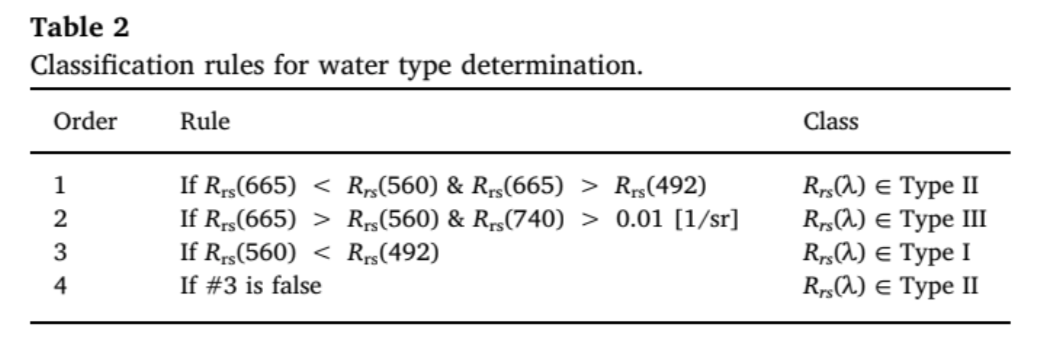


In [69]:
#get same image as Csaba
image= cloudmask(ee.Image('COPERNICUS/S2_SR/20200116T155609_20200116T155605_T18SUJ'))
Map.addLayer(image,imageVisParam,"image")


# B4 - R(665)
# B3 - R(560)
# B2 - R(492)
# B6 - R(740)

def watertype(img):  #get some eyes on the sequence of these logics in sequence
  b4 = img.select("B4")
  b3 = img.select("B3")
  b2 = img.select("B2")
  b6 = img.select("B6")
  
  typeII = b4.lt(b3).And(b4.gt(b2))
  typeIII= b4.gt(b3).And(b6.gt(.01)).And(typeII.eq(0)) #"sr" part unclear to me?
  typeI = b3.lt(b2).And(typeIII.eq(0)).And(typeII.eq(0))
  typeIV = b3.gte(b2).And(typeI.eq(0)).And(typeII.eq(0)).And(typeIII.eq(0))

  return img.addBands([typeII.rename('typeII'),typeIII.rename('typeIII'),typeI.rename('typeI'),typeIV.rename("typeIV")])

image=watertype(image)

Map.addLayer(image,imageVisParam,"bands+watertype")

image=image.select(["typeII",'typeIII','typeI',"typeIV"])

Map.addLayer(image,[],"watertype")




Ok. Now lets make some functions to run in the various scenarios. Simple ones to start. These would be the TSS process(s) once we get those going for each different water type.

In [70]:
def typeII(img):
  TSS=ee.Image(2).float().rename("TSS")
  return TSS

def typeIII(img):
  TSS=ee.Image(3).float().rename("TSS")
  return TSS

def typeI(img):
  TSS=ee.Image(1).float().rename("TSS")
  return TSS

def typeIV(img):
  TSS=ee.Image(4).float().rename("TSS")
  return TSS

#test=typeIII(image)
#print(test)
#Map.addLayer(test,[],"func")

Run the functions over images based on the conditional logic of which function for what pixel

In [74]:

def TSSit(img): #well, it works, but doesnt look perfect in terms of efficiency
  img2=img
  datamask = img2.select('typeII')
  mask = datamask.eq(1)
  TSSII = typeII(img2).select("TSS")
  TSSII = TSSII.updateMask(mask)

  img3=img
  datamask2 = img3.select('typeIII')
  mask2 = datamask2.eq(1)
  TSSIII = typeIII(img3).select("TSS")
  TSSIII = TSSIII.updateMask(mask2)

  img4=img
  datamask3 = img4.select('typeI')
  mask3 = datamask3.eq(1)
  TSSI = typeI(img4).select("TSS")
  TSSI = TSSI.updateMask(mask3)

  img5=img
  datamask4 = img5.select('typeIV')
  mask4 = datamask4.eq(1)
  TSSIV = typeIV(img5).select("TSS")
  TSSIV = TSSIV.updateMask(mask4)

  #return TSSI
  mosaic=ee.ImageCollection([TSSII,TSSIII,TSSI,TSSIV]).mosaic()
  return mosaic

TSSf=TSSit(image)

viz = {'min': 1, 'max': 4, 'palette': ['00FFFF', '0000FF']}

Map.addLayer(TSSf,viz,"TSSII")



#def TSSit(img): #this kind of thing might work too or an expression style at the bottom?

 # replacementII=typeII(img)
 # replacementIII=typeIII(img)
  #replacementI=typeI(img)
 # replacementIV=typeIV(img)

  #TSS = img.where(img.select("typeII"),replacementII)
  #TSS = img.where(img.select("typeIII"),replacementIII)
 # TSS = img.where(img.select("typeI"), replacementI)
 # TSS = img.where(img.select("typeIV"),replacementIV)

 # return TSS


#test=TSSit(image)

#Map.addLayer(test,[],"TSSit")


#hmm maybe more like this 
# Create zones using an expression, display.


#zones_exp = nl_2012.expression("(b('stable_lights') > 62) ? 3 "
#                               ": (b('stable_lights') > 55) ? 2 "
#                               ": (b('stable_lights') > 30) ? 1 "
#                               ": 0")

#or maybe mosaic it>


In [77]:
Map


Point (-76.3745, 39.2708) at 38m/px
TSSII: Image (1 band)
  TSS: 4
